In [12]:
# import all the relevant libraries

import numpy as np
#import numpy.random
import matplotlib.pyplot as plt

import tensorflow as tf
import h5py

import keras
from keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input, InputLayer, Dropout
import keras.layers.merge as merge
from keras.layers.merge import Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam

%matplotlib inline

In [13]:
print(tf.config.list_physical_devices('CPU'))
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()
print([x.name for x in local_device_protos if x.device_type == 'GPU' or x.device_type == 'CPU'])

['/device:CPU:0', '/device:GPU:0']


2021-11-03 01:30:32.862011: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-03 01:30:32.864173: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:16:00.0 name: NVIDIA Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-11-03 01:30:32.864211: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-03 01:30:32.864231: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-03 01:30:32.864240: I tensorflow/stream_e

In [14]:
# load data and check the train-test split shape and size

(x_train, y_train), (x_valid, y_valid) = cifar100.load_data()
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_valid.shape, y_valid.shape))
nb_classes = set(y_train.flatten())
print('number of classes= %s' %len(nb_classes))
print(type(x_train))

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)
number of classes= 100
<class 'numpy.ndarray'>


In [5]:
# convert data to HDF5 format

with h5py.File('cifar100_dataset.hdf5', 'w') as hf:
    dset_x_train = hf.create_dataset('x_train', data=x_train, shape=(50000, 32, 32, 3), compression='gzip', chunks=True)
    dset_y_train = hf.create_dataset('y_train', data=y_train, shape=(50000, 1), compression='gzip', chunks=True)
    dset_x_test = hf.create_dataset('x_valid', data=x_valid, shape=(10000, 32, 32, 3), compression='gzip', chunks=True)
    dset_y_test = hf.create_dataset('y_valid', data=y_valid, shape=(10000, 1), compression='gzip', chunks=True)

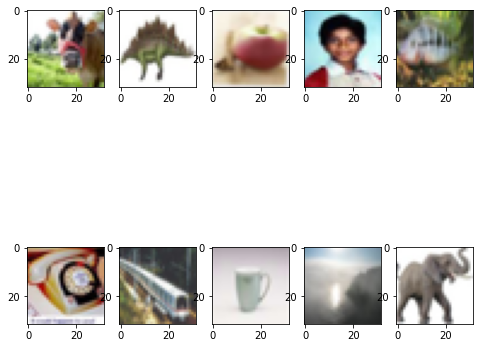

In [15]:
plt.figure(figsize=(8, 8)) 
for i in range(2*5):
    # define subplot
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i])
    #plt.title(class_names[class_index], fontsize=9)

In [16]:
# Define the model

model = tf.keras.Sequential()
model.add(InputLayer(input_shape=[32, 32, 3]))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

#model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
#model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

#model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
#model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(100, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               1048832   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)              

In [19]:
# Define the data generator

class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, filename, batch_size, test=False, shuffle=True):
        
        self.PATH_TO_FILE = filename
        
        self.hf = h5py.File(self.PATH_TO_FILE, 'r')         
        self.batch_size = batch_size
        self.test = test
        self.shuffle = shuffle
        self.on_epoch_end()

    def __del__(self):
        self.hf.close()
        
    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        start = self.batch_size * idx
        stop = self.batch_size * (idx+1)
        
        if self.test:
            x = self.hf['x_valid'][start:stop, ...]
            batch_x = np.array(x).astype('float32') / 255.0
            y = self.hf['y_valid'][start:stop]
            batch_y = to_categorical(np.array(y), 100)
        else:
            x = self.hf['x_train'][start:stop, ...]
            batch_x = np.array(x).astype('float32') / 255.0
            y = self.hf['y_train'][start:stop]
            batch_y = to_categorical(np.array(y), 100)

        return batch_x, batch_y

    def on_epoch_end(self):
        if self.test:
            self.indices = np.arange(self.hf['x_valid'][:].shape[0])
        else:
            self.indices = np.arange(self.hf['x_train'][:].shape[0])
            
        if self.shuffle:
            np.random.shuffle(self.indices)

In [20]:
# generate batches of data for training and validation dataset

filename = 'cifar100_dataset.hdf5'

batchsize  = 50 
data_train = DataGenerator(filename, batch_size=batchsize)
data_valid = DataGenerator(filename, batch_size=batchsize, test=True, shuffle=False)

In [25]:
optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
history = model.fit(data_train,epochs=20,
                    verbose=1, validation_data=data_valid)

Epoch 1/20
1000/1000 [==============================] - 98s 98ms/step - loss: 3.5798 - accuracy: 0.1508 - val_loss: 3.3216 - val_accuracy: 0.1996
Epoch 2/20
1000/1000 [==============================] - 98s 98ms/step - loss: 3.2962 - accuracy: 0.1972 - val_loss: 3.2063 - val_accuracy: 0.2265
Epoch 3/20
1000/1000 [==============================] - 98s 98ms/step - loss: 3.1295 - accuracy: 0.2260 - val_loss: 3.1241 - val_accuracy: 0.2447
Epoch 4/20
1000/1000 [==============================] - 98s 98ms/step - loss: 3.0013 - accuracy: 0.2498 - val_loss: 3.0124 - val_accuracy: 0.2651
Epoch 5/20
1000/1000 [==============================] - 98s 98ms/step - loss: 2.8430 - accuracy: 0.2822 - val_loss: 2.9267 - val_accuracy: 0.2870
Epoch 6/20
1000/1000 [==============================] - 98s 98ms/step - loss: 2.7114 - accuracy: 0.3027 - val_loss: 2.8747 - val_accuracy: 0.2953
Epoch 7/20
1000/1000 [==============================] - 98s 98ms/step - loss: 2.6103 - accuracy: 0.3268 - val_loss: 2.8596 -

Exception ignored in: <function DataGenerator.__del__ at 0x2b5a4719a820>
Traceback (most recent call last):
  File "/tmp/ipykernel_33820/2874381892.py", line 16, in __del__
AttributeError: 'DataGenerator' object has no attribute 'hf'


1000/1000 [==============================] - 98s 98ms/step - loss: 2.2983 - accuracy: 0.3876 - val_loss: 2.8177 - val_accuracy: 0.3147
Epoch 11/20
1000/1000 [==============================] - 98s 98ms/step - loss: 2.2013 - accuracy: 0.4090 - val_loss: 2.8186 - val_accuracy: 0.3181
Epoch 12/20
1000/1000 [==============================] - 98s 98ms/step - loss: 2.1256 - accuracy: 0.4249 - val_loss: 2.8044 - val_accuracy: 0.3216
Epoch 13/20
1000/1000 [==============================] - 98s 98ms/step - loss: 2.0559 - accuracy: 0.4389 - val_loss: 2.8510 - val_accuracy: 0.3228
Epoch 14/20
1000/1000 [==============================] - 98s 98ms/step - loss: 1.9657 - accuracy: 0.4606 - val_loss: 2.8873 - val_accuracy: 0.3181
Epoch 15/20
1000/1000 [==============================] - 95s 95ms/step - loss: 1.9258 - accuracy: 0.4711 - val_loss: 2.8692 - val_accuracy: 0.3242
Epoch 16/20
1000/1000 [==============================] - 95s 95ms/step - loss: 1.8483 - accuracy: 0.4876 - val_loss: 2.9171 - val_

In [27]:
new_filename = '/home/ajaiswal/lus_scratch/cifar100_dataset.hdf5'

batchsize  = 400 
data_train_lus = DataGenerator(new_filename, batch_size=batchsize)
data_valid_lus = DataGenerator(new_filename, batch_size=batchsize, test=True, shuffle=False)

In [30]:
from tensorflow.keras.models import clone_model
new_model = clone_model(model)
optimizer = keras.optimizers.Adam(lr=0.0001)
new_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
new_history = new_model.fit(data_train_lus,epochs=30,
                    verbose=1, validation_data=data_valid_lus)

Epoch 1/30
125/125 [==============================] - 15s 117ms/step - loss: 4.5740 - accuracy: 0.0172 - val_loss: 4.2580 - val_accuracy: 0.0556
Epoch 2/30
125/125 [==============================] - 15s 116ms/step - loss: 4.2148 - accuracy: 0.0568 - val_loss: 3.9323 - val_accuracy: 0.1100
Epoch 3/30
125/125 [==============================] - 15s 117ms/step - loss: 3.9715 - accuracy: 0.0911 - val_loss: 3.7553 - val_accuracy: 0.1417
Epoch 4/30
125/125 [==============================] - 15s 116ms/step - loss: 3.8109 - accuracy: 0.1181 - val_loss: 3.6064 - val_accuracy: 0.1671
Epoch 5/30
125/125 [==============================] - 15s 116ms/step - loss: 3.6892 - accuracy: 0.1385 - val_loss: 3.5081 - val_accuracy: 0.1816
Epoch 6/30
125/125 [==============================] - 15s 116ms/step - loss: 3.5856 - accuracy: 0.1571 - val_loss: 3.4213 - val_accuracy: 0.1967
Epoch 7/30
125/125 [==============================] - 15s 116ms/step - loss: 3.5011 - accuracy: 0.1672 - val_loss: 3.3499 - val_ac